In [1]:
import numpy as np
import torch
from transformers import *
from sklearn.cluster import KMeans
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

You are using torchaudio==0.9.0, but torchaudio>=0.10.0 is required to use MCTCTFeatureExtractor. This requires torch>=1.10.0. Please upgrade torch and torchaudio.
You are using torch==1.9.0+cu111, but torch>=1.10.0 is required to use ViltModel. Please upgrade torch.


cuda


In [55]:
train_embeddings = {}
test_embeddings = {}
sents = np.load('distilBERT/sentences.npy')
vectors = np.load('distilBERT/vectors.npy')
domain = np.load('distilBERT/domain.npy')
sentiment = np.load('distilBERT/sentiment.npy')

split = int(0.8 * len(sents))
train_embeddings['sents'] = sents[:split]
train_embeddings['vectors'] = vectors[:split]
train_embeddings['domain'] = domain[:split]
train_embeddings['sentiment'] = sentiment[:split]
test_embeddings['sents'] = sents[split:]
test_embeddings['vectors'] = vectors[split:]
test_embeddings['domain'] = domain[split:]
test_embeddings['sentiment'] = sentiment[split:]

In [59]:
DOMAINS = ['Automotive', 'Books', 'Music', 'Software', 'Baby']
N_CLUSTERS = 5

def kmeans(train_data, num_clusters=5):
    model = KMeans(n_clusters=num_clusters,
                   max_iter=250,
                   random_state=1,
                   verbose=1)
    
    model.fit(train_data)
    return model


def get_predictions(model, test_data):
    return model.predict(test_data)


def assign_labels_to_clusters(true_labels, predictions, num_clusters=8):
    cluster_assignment = {}
    true_count = 0
    total = 0
    for k in range(num_clusters):
        count = [0] * len(DOMAINS)
        for i, pred in enumerate(predictions):
            if pred == k:
                count[DOMAINS.index(true_labels[i])] += 1
        max_count = max(count)
        total_count = sum(count)
        cluster_assignment[k] = (DOMAINS[count.index(max_count)], max_count, total_count)
        true_count += max_count
        total += total_count
    acc = true_count / total
    return cluster_assignment, acc


def calc_test_accuracy(true_labels, predictions, cluster_assignment):
    total = 0
    true_count = 0
    for i, pred in enumerate(predictions):
        if cluster_assignment[pred][0] == true_labels[i]:
            true_count +=1
        total += 1
    return true_count / total

In [60]:
start = time.time()
model = kmeans(train_embeddings['vectors'], N_CLUSTERS)
end  = time.time()
print(f"Time taken to converge: {(end-start) / 3600} hrs.")

Initialization complete
Iteration 0, inertia 632496.0
Iteration 1, inertia 394097.625
Iteration 2, inertia 386539.4375
Iteration 3, inertia 382001.1875
Iteration 4, inertia 379790.75
Iteration 5, inertia 378183.28125
Iteration 6, inertia 376053.5
Iteration 7, inertia 373897.9375
Iteration 8, inertia 372121.21875
Iteration 9, inertia 371067.65625
Iteration 10, inertia 370710.8125
Iteration 11, inertia 370626.125
Iteration 12, inertia 370605.71875
Iteration 13, inertia 370599.78125
Iteration 14, inertia 370597.40625
Iteration 15, inertia 370596.78125
Iteration 16, inertia 370596.21875
Iteration 17, inertia 370595.78125
Iteration 18, inertia 370595.6875
Iteration 19, inertia 370595.3125
Iteration 20, inertia 370595.28125
Iteration 21, inertia 370595.15625
Iteration 22, inertia 370595.0
Iteration 23, inertia 370595.09375
Iteration 24, inertia 370595.125
Converged at iteration 24: center shift 4.307830465677398e-07 within tolerance 1.4255304820835591e-06.
Initialization complete
Iteration 0

Iteration 14, inertia 365000.0
Iteration 15, inertia 364999.0
Iteration 16, inertia 364998.375
Iteration 17, inertia 364997.90625
Iteration 18, inertia 364997.75
Iteration 19, inertia 364997.53125
Iteration 20, inertia 364997.625
Converged at iteration 20: center shift 8.638849635644874e-07 within tolerance 1.4255304820835591e-06.
Initialization complete
Iteration 0, inertia 592545.9375
Iteration 1, inertia 387703.46875
Iteration 2, inertia 379106.5
Iteration 3, inertia 374236.3125
Iteration 4, inertia 371653.5
Iteration 5, inertia 369646.6875
Iteration 6, inertia 367493.78125
Iteration 7, inertia 366293.0625
Iteration 8, inertia 365690.21875
Iteration 9, inertia 365369.1875
Iteration 10, inertia 365202.5
Iteration 11, inertia 365115.375
Iteration 12, inertia 365069.15625
Iteration 13, inertia 365041.8125
Iteration 14, inertia 365026.96875
Iteration 15, inertia 365017.75
Iteration 16, inertia 365012.09375
Iteration 17, inertia 365008.1875
Iteration 18, inertia 365005.6875
Iteration 19,

In [61]:
train_pred = get_predictions(model, train_embeddings['vectors'])
cluster_assignment, accuracy = assign_labels_to_clusters(train_embeddings['domain'], train_pred, N_CLUSTERS)
print(f"Train accuracy is {accuracy:.4f}")

test_pred = get_predictions(model, test_embeddings['vectors'])
test_accuracy = calc_test_accuracy(test_embeddings['domain'], test_pred, cluster_assignment)
print(f"Test accuracy is {test_accuracy:.4f}")

np.save('test_pred_kmeans_k5_distilBERT.npy', test_pred)

Train accuracy is 0.7311
Test accuracy is 0.7402


In [62]:
for k in range(N_CLUSTERS):
    print(f'Cluster-{k+1} | label: {cluster_assignment[k][0]} | Purity: {cluster_assignment[k][1]/cluster_assignment[k][2]}')

Cluster-1 | label: Books | Purity: 0.8974130240856378
Cluster-2 | label: Baby | Purity: 0.5234356412086605
Cluster-3 | label: Automotive | Purity: 0.45098777046095956
Cluster-4 | label: Software | Purity: 0.8785674314493565
Cluster-5 | label: Music | Purity: 0.9778279903968367


In [44]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

tsne = TSNE(n_components=2, verbose=1, random_state=1)
z = tsne.fit_transform(test_embeddings['vectors'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...


/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 10000 samples in 3.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.983668
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.612320
[t-SNE] KL divergence after 1000 iterations: 2.728694


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

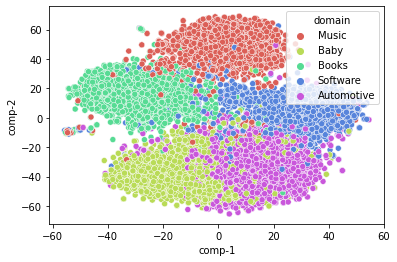

In [45]:
df = pd.DataFrame()
df["domain"] = test_embeddings['domain']
df["clusters"] = [cluster_assignment[pred][0] for pred in test_pred]
# df["clusters"] = test_pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="domain", palette=sns.color_palette("hls", 5))

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

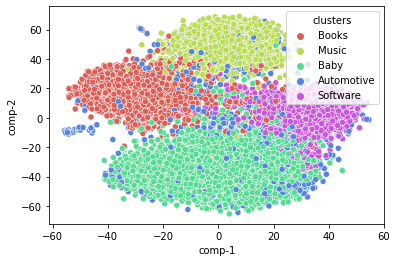

In [46]:
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="clusters", palette=sns.color_palette("hls", 5))